E:\venvs\siam-mot\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


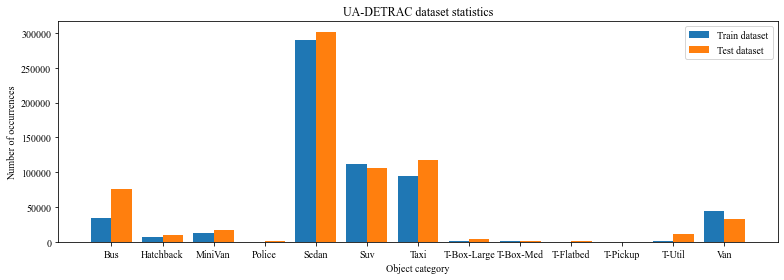

In [1]:
#  grep --include="*.xml" -oR -P 'vehicle_type="[-a-zA-Z]*' | cut -c 32- | sort | uniq -c

import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Times New Roman'

stats_train = """
  34405 Bus
   6209 Hatchback
  12784 MiniVan
    348 Police
 289277 Sedan
 111610 Suv
  94929 Taxi
    660 Truck-Box-Large
   1588 Truck-Box-Med
    257 Truck-Flatbed
    329 Truck-Pickup
    945 Truck-Util
  44940 Van
"""

stats_test = """
  75624 Bus
   9205 Hatchback
  16695 MiniVan
    474 Police
 301555 Sedan
 105964 Suv
 116932 Taxi
   3611 Truck-Box-Large
   1609 Truck-Box-Med
   1158 Truck-Flatbed
      0 Truck-Pickup
  10547 Truck-Util
  32400 Van
"""

def split_txt_stats(txt_stats):
    for line in filter(lambda l: l, txt_stats.split("\n")):
        tokens = line.split()
        category, count = tokens[1].replace('Truck', 'T'), int(tokens[0])
        yield category, count

def plot_train_test_datasetbar_chart(
    ax, xs_train, xs_test, labels, title, width=0.4
):
    x = np.arange(len(labels))

    ax.bar(x - width / 2, xs_train, width, label="Train dataset")
    ax.bar(x + width / 2, xs_test, width, label="Test dataset")

    ax.set_title(title)
    ax.set_xlabel("Object category")
    ax.set_ylabel("Number of occurrences")
    ax.set_xticks(x)
    ax.set_xticklabels(labels)

    ax.legend()

labels = []
xs_train, xs_test = [], []

data_train = split_txt_stats(stats_train)
data_test = split_txt_stats(stats_test)

for (label, x_train), (_, x_test) in zip(data_train, data_test):
    labels.append(label)
    xs_train.append(x_train)
    xs_test.append(x_test)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 4))
plot_train_test_datasetbar_chart(
    ax, xs_train, xs_test, labels, "UA-DETRAC dataset statistics"
)
fig.tight_layout()
fig.savefig('./ua_detrac_dataset_stats.png', dpi=300)
fig.show()

In [4]:
import json

with open('E:/anno.json', 'rt') as file:
    content = json.load(file)

In [6]:
content['metadata']

{'description': 'UA-DETRAC benchmark dataset XML ingestion',
 'key_hash': 0,
 'last_modified': '2021-10-09 06:55:41.382394',
 'version': '1.0.0.'}